In [ ]:
# Run this cell to download the course materials and functions.
import os
import sys

# Clone the repository
!git clone https://github.com/Stephen-Robbins/Math_of_Finance.git

# Change directory to the repository's root
%cd Math_of_Finance

# --- Important: Add the 'scripts' directory to Python's search path ---
# Get the absolute path to the 'scripts' folder. This is crucial for portability.
scripts_path = os.path.join(os.getcwd(), "scripts")

# Add the scripts directory to Python's path
if scripts_path not in sys.path:  # Avoid adding it multiple times
    sys.path.insert(0, scripts_path)

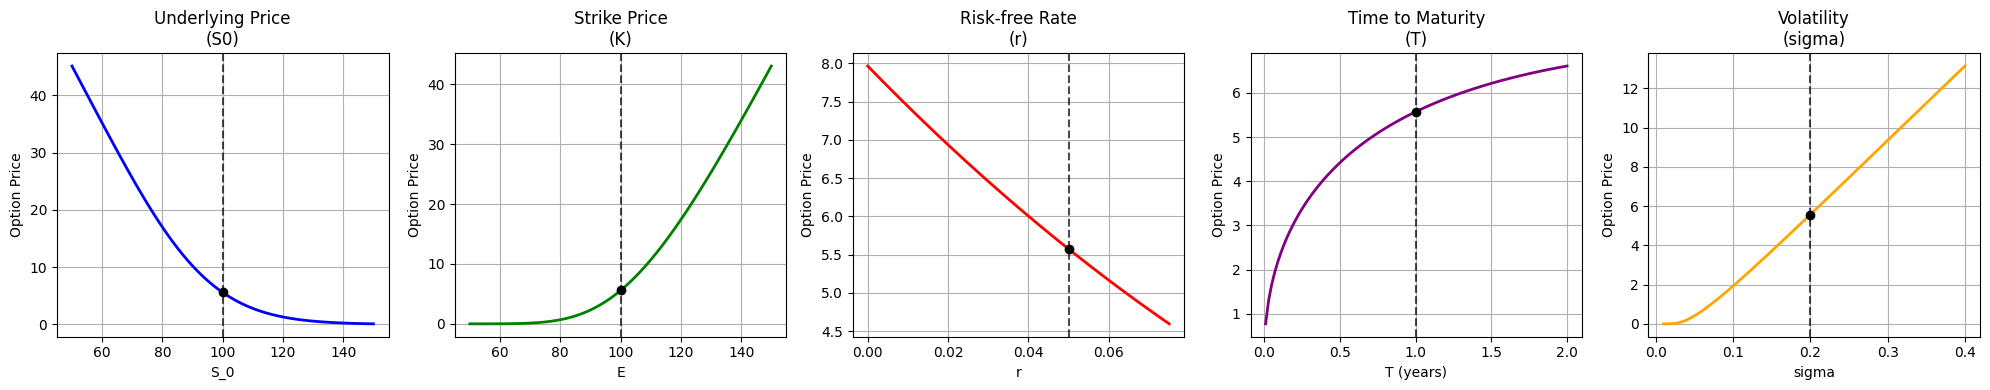

In [ ]:
from plot import plot_bs_option_sensitivity

# Example parameters:
option_type = 'call'    # or 'put'
S0 = 100                # current stock price
E = 100                 # strike price
r = 0.05                # risk-free rate (5%)
T = 1                   # time to maturity (1 year)
sigma = 0.2             # volatility (20%)

plot_bs_option_sensitivity(option_type, S0, E, r, T, sigma)


In [3]:
from plot import interactive_bs_s0_plot

# Launch the interactive widget (for a call option; change option_type to 'put' if desired)
interactive_bs_s0_plot(option_type="call", base_S0=100)

interactive(children=(FloatSlider(value=100.0, description='Strike (K)', max=150.0, min=50.0, step=1.0), Float…

In [4]:
from finance import monte_carlo_option_price, black_scholes_call_price
import numpy as np

# Example parameters:
S0 = 100    # current stock price
E = 100        # strike price (E)
r = 0.05       # risk-free interest rate (5%)
T = 1          # time to maturity (1 year)
sigma = 0.2    # volatility (20%)
n_sims = 1000000 # number of Monte Carlo simulations
custom_payoff  = lambda S_T: np.maximum(S_T- E, 0)
bs_price=black_scholes_call_price(S0, E, r, T, sigma)
mc_price = monte_carlo_option_price(S0, E, r, T, sigma, payoff_func=custom_payoff, n_sims=n_sims)
print(f"Monte Carlo  Option Price: {mc_price:.4f}")
print(f"Black-Scholes Call Option Price: {bs_price:.4f}")

Monte Carlo  Option Price: 10.4563
Black-Scholes Call Option Price: 10.4506


**Goal:** Replicate a European call option's payoff, $\max(S_T - E, 0)$, using a self-financing portfolio of the underlying stock ($S$) and a risk-free asset ($B$).

**Assumptions:** Black-Scholes world (Geometric Brownian Motion for $S$, constant risk-free rate $r$, no arbitrage, continuous trading). The stock price follows: $dS_t = \mu S_t dt + \sigma S_t dW_t$.

**Delta ($\Delta$):** Sensitivity of the option price ($C$) to changes in the stock price: $\Delta = \frac{\partial C}{\partial S} = N(d_1)$, where $d_1 = \frac{\ln(S/E) + (r + \sigma^2/2)(T - t)}{\sigma\sqrt{T - t}}$.

**Portfolio:**
*   $\Pi(t) = \Delta S_t + B$
*   $\Delta$ shares of stock.
*   $B$ amount in the risk-free asset (cash or bond).

**Self-Financing Condition:** Changes in the portfolio value arise *only* from changes in asset prices:
*   $d\Pi(t) = \Delta dS_t + rBdt$

**Replication:** We require $d\Pi(t) = dC(S_t, t)$. Applying Ito's Lemma to $dC$:
$$dC = \frac{\partial C}{\partial t}dt + \frac{\partial C}{\partial S}dS_t + \frac{1}{2}\frac{\partial^2 C}{\partial S^2}\sigma^2 S_t^2 dt$$
Equating coefficients of $dS_t$ and $dt$ with the self-financing condition ($d\Pi = dC$) gives:
$$\Delta = \frac{\partial C}{\partial S}$$  
$$rB = \frac{\partial C}{\partial t} + \frac{1}{2}\frac{\partial^2 C}{\partial S^2}\sigma^2 S_t^2.$$ 
Combining this with $\Pi = \Delta S + B$ and the Black-Scholes equation, we find $B = -Ee^{-r(T-t)}N(d_2)$.

**Rebalancing:** Continuously adjust $\Delta$ (and therefore $B$) as $S$ and $t$ change to maintain $d\Pi = dC$. This ensures $\Pi(T) = \max(S_T - E, 0)$.

**Discrete Approximation (Code Implementation):**

The Python code simulates delta hedging *discretely*.  The `replicating_portfolio` function implements the strategy as follows:

1.  **Initialization:** At $t=0$, the initial option price ($C_0$) and delta ($\Delta_0$) are calculated using Black-Scholes formulas. The initial portfolio is constructed: $\Pi(0) = \Delta_0 S_0 + B_0$, where $B_0 = C_0 - \Delta_0 S_0$.

2.  **Time Stepping:** The simulation proceeds in discrete time steps, $\Delta t$.  At each step $t_i$:
*   The stock price, $S_{t_i}$, is obtained from the simulated Geometric Brownian Motion path.
*   The new delta, $\Delta_{t_i} = N(d_1)$, is calculated using the current stock price $S_{t_i}$ and remaining time to maturity $T - t_i$.
*   **Rebalancing:** The portfolio is rebalanced to hold $\Delta_{t_i}$ shares of stock. The cash account ($B$) is adjusted to maintain the self-financing condition. Specifically, the value of the portfolio *before* rebalancing ($V_{pre}$) is equal to the value *after* rebalancing. The new bank account value is calculated as: $B_{t_i} = V_{pre} - \Delta_{t_i} S_{t_i}$, where  $V_{pre} = B_{t_{i-1}}e^{r\Delta t} + \Delta_{t_{i-1}} S_{t_i}$ .
*   The portfolio value is updated: $\Pi(t_i) = \Delta_{t_i}S_{t_i} + B_{t_i}$.  Due to the self-financing nature, the portfolio value changes only due to the evolution of $S$ and the interest earned on $B$.

3.  **Iteration:** Steps are repeated until expiration ($T$). The discrete rebalancing approximates the continuous delta hedging, aiming for $\Pi(T) \approx \max(S_T - E, 0)$.

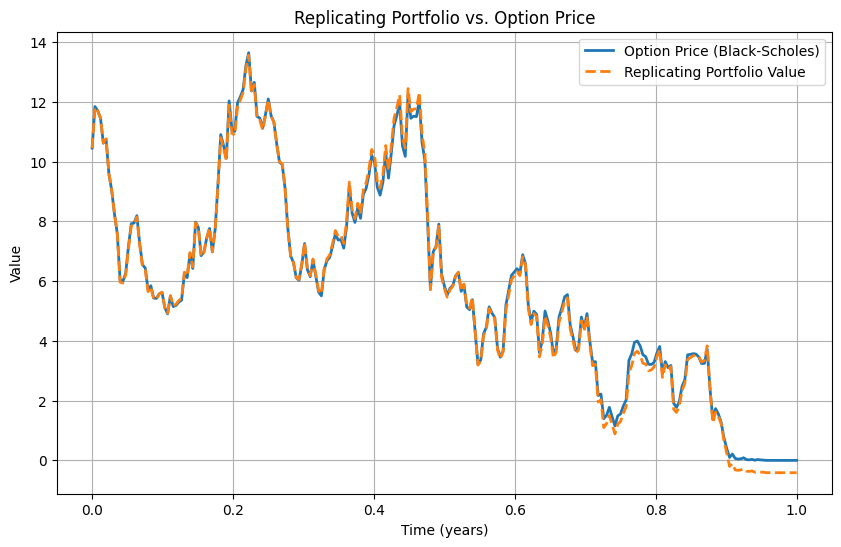

In [8]:
import numpy as np
from option_hedging import replicating_portfolio
import matplotlib.pyplot as plt

# Example: Replicating portfolio demonstration.
time_grid, opt_prices, port_values, stock_path = replicating_portfolio(
    S0=100, E=100, r=0.05, T=1.0, sigma=0.2, n_steps=252
)

plt.figure(figsize=(10, 6))
plt.plot(time_grid, opt_prices, label='Option Price (Black-Scholes)', lw=2)
plt.plot(time_grid, port_values, label='Replicating Portfolio Value', lw=2, linestyle='--')
plt.xlabel('Time (years)')
plt.ylabel('Value')
plt.title('Replicating Portfolio vs. Option Price')
plt.legend()
plt.grid(True)
plt.show()




**Scenario: Apple (AAPL) Call Option Mispricing**

Let's assume:

*   Current AAPL stock price ($S_0$): $150
*   Strike price ($E$) of a European call option: $160
*   Time to maturity ($T$): 1 year
*   Risk-free rate ($r$): 0.05 (5%)
*   Market Implied Volatility ($IV$): 0.20 (20%) - This is the volatility used to price the option in the market.
*   Your Estimated Realized Volatility ($\sigma_R$): 0.30 (30%) - You believe the *true* volatility of AAPL stock over the next year will be higher.

Since $IV < \sigma_R$, the option is undervalued according to your estimate.


In [7]:
from option_hedging import arbitrage_simulation
import matplotlib.pyplot as plt
# --- Simulation Parameters ---
S0 = 150       # Initial stock price
E = 150        # Strike price (at-the-money is best)
r = 0.05       # Risk-free rate
T = 1          # Time to maturity (years)
IV = 0.20      # Implied volatility (market)
sigma_R = 0.30   # Realized volatility (your estimate)
n_steps = 252*10    # Number of time steps (daily)


# --- Run the Simulation ---
arbitrage_profit, realized_arbitrage_profit = arbitrage_simulation(S0, E, r, T, IV, sigma_R, n_steps)

print("theoretical arbitrage profit: ", arbitrage_profit)
print("realized arbitrage profit: ", realized_arbitrage_profit)


theoretical arbitrage profit:  5.67100682070037
realized arbitrage profit:  5.685671831179462
